* load lightning module from checkpoints
* eval models with various decision score on metrics
* visualisation sample

In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

### Load config from run

Inside a Lightning checkpoint you’ll find:

* 16-bit scaling factor (if using 16-bit precision training)
* Current epoch
* Global step
* LightningModule’s state_dict
* State of all optimizers
* State of all learning rate schedulers
* State of all callbacks (for stateful callbacks)
* State of datamodule (for stateful datamodules)
* The hyperparameters (init arguments) with which the model was created
* The hyperparameters (init arguments) with which the datamodule was created 
* State of Loops

In [2]:
_SHARE_PATH = "levir-cd/vit-b"

def _cfg_meta(exp_name, id_exp, folder_root=None, description=""):
    """generate register items - to be updated"""
    if folder_root is None: folder_root = ""
    cfg = {
        "path": make_path(
                    id_exp, 
                    LOGS_PATH, 
                    "final_logs",
                    folder_root,
                    exp_name,
                    _SHARE_PATH
                ),
        "description": description
    }

    if not os.path.exists(cfg["path"]): 
        raise FileNotFoundError(f"Exp run logs not found :{cfg['path']}")
    return cfg

# TODO: integrate in src/
_register_runs = {
    # PROBING
    "probing_concat_baseline": 
        _cfg_meta("train_probing_concat", "2024-08-07_17-50-07", folder_root="08082024_train_first_modules", description=""),
    "probing_diff_baseline":
        _cfg_meta("train_probing_diff", "2024-08-07_17-50-30", folder_root="08082024_train_first_modules", description=""),
    "probing_attn_baseline":
        _cfg_meta("train_probing_attn", "2024-08-07_17-51-53", folder_root="08082024_train_first_modules", description=""),
    # ADAPTER
    "adapter_diff":
        _cfg_meta("train_adapter_diff", "2024-08-07_17-52-31", folder_root="08082024_train_first_modules", description=""),
    "_adapter_concat":
        _cfg_meta("train_adapter_concat", "2024-08-07_17-53-32", folder_root="08082024_train_first_modules", description=""),
    "adapter_attn":
        _cfg_meta("train_adapter_attn", "2024-08-07_18-15-08", folder_root="08082024_train_first_modules", description=""),
    # LORA
    "lora_diff":
        _cfg_meta("train_lora_diff", "2024-08-07_18-22-22", folder_root="08082024_train_first_modules", description=""),
    "lora_concat":
        _cfg_meta("train_lora_concat", "2024-08-07_18-21-49", folder_root="08082024_train_first_modules", description=""),
    "lora_attn":
        _cfg_meta("train_lora_attn", "2024-08-07_18-22-20", folder_root="08082024_train_first_modules", description=""),
    "lora_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("lora_attnconc_focal_dice_lr5x10-4", "1448002", folder_root="", description=""),
    # EXPLO lr ADAPTER
    "adapter_attnconc_bce_lr3x10-4":
        _cfg_meta("adapter_attnconc_bce_lr3x10-4", "1387852", folder_root="", description=""),
    "adapter_attnconc_bce_lr10-4":
        _cfg_meta("adapter_attnconc_bce_lr10-4", "1380222", folder_root="", description=""),
    "adapter_attnconc_bce_lr5x10-4":
        _cfg_meta("adapter_attnconc_bce_lr5x10-4", "1447907", folder_root="", description=""),
    "adapter_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("adapter_attnconc_focal_dice_lr5x10-4", "1447968", folder_root="", description=""),


}

def find_best_ckpt(run_path):
    run_path = os.path.join(run_path, "checkpoints")
    fname = [_ for _ in os.listdir(run_path) if _.startswith("epoch_")]
    if fname:
        fname=fname[0]
    else:
        raise ValueError("ckpt not found")
    return make_path(fname, run_path)

def check_exp(exp_name):
    if exp_name not in _register_runs:
        raise ValueError(f"Exp name {exp_name} not found")

def _cfg_path(exp_name):
    check_exp(exp_name)
    return make_path(
        ".hydra/config.yaml",
        _register_runs[exp_name]["path"],
        )

def _ckpt_path(exp_name):
    check_exp(exp_name)
    return find_best_ckpt(_register_runs[exp_name]["path"])

def load_default_loss():
    return nn.BCEWithLogitsLoss()

In [3]:
#model.optimzier.load_state_dict(MyMode.load_optimizer_checkpoint(last_checkpoint))

In [4]:
def load_cfg(exp_name):
    return OmegaConf.load(_cfg_path(exp_name))


def load_params_module(cfg):
    scheduler, optimizer = None, None
    loss = load_default_loss()
    model = hydra.utils.instantiate(cfg.model.instance.network)
    if "optimizer" in cfg.model:
        optimizer = hydra.utils.instantiate(cfg.model.optimizer)
    if "scheduler" in cfg.model:
        scheduler = hydra.utils.instantiate(cfg.model.scheduler)
    if "loss" in cfg.model:
        loss = hydra.utils.instantiate(cfg.model.loss)
        
    return dict(model=model, optimizer=optimizer, scheduler=scheduler, loss=loss, task_name=cfg.task_name)

def load_dmodule(cfg):
    return hydra.utils.instantiate(cfg.data)

def load_lmodule(exp_name, params):
    return MagicPenModule.load_from_checkpoint(
        _ckpt_path(exp_name),
        optimizer=params.get("optimizer"),
        scheduler=params.get("scheduler"),
        loss=params.get("loss"),
        network = params.get("model"),
        task_name=params.get("task_name")
    )

def load_exp(exp_name):
    
    cfg = load_cfg(exp_name)
    params = load_params_module(cfg)
    data_module = load_dmodule(cfg)
    module = load_lmodule(exp_name, params)
    
    return cfg, data_module, module

In [5]:
# exp_name = "probing_concat_baseline"
# cfg, data_module, module = load_exp(exp_name)

#### Restoring Training State
If you don’t just want to load weights, but instead restore the full training, do the following:
```
model = LitModel()
trainer = Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)
```

### Run inference

In [6]:
def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

def get_ds(mode: str, dmodule):
    
    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
        
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
        
    return dmodule.ds_dict_type[mode]

In [7]:
# dloader = get_dloader("test", data_module)
# ds = get_ds("test", data_module)

In [8]:
# batch = next(iter(dloader))

In [9]:
# show_sample_from_batch(batch, idx=0)

In [10]:
def infer_on_sample(ds, module, fname=None, fidx=None):
    if not any([fname, fidx]):
        raise ValueError("Please provide at least a sample name or an sample index")
    # priority to fname
    if fname is not None:
        fidx = ds.get_from_name(fname, return_sample=False)
    # TODO: allow indices sequence
    if isinstance(fidx, int): fidx = [fidx]
    sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
    batch = next(iter(sub_dl))

    # workaround  prevent wrong device association buffers in SAM
    # module = module.to("cpu")
    preds, _ = module(batch)
    # B x 1 x 1024 x 1024
    preds = preds.squeeze().detach().cpu()
    label = label.squeeze().detach().cpu()
    return preds, label, batch

In [11]:
def convert_to_device(batch, device="cuda"):
    for name in ['img_A', 'img_B', 'label', 'point_coords', 'point_labels']:
        batch[name] = batch[name].to(device)
    return batch

### Eval on instances

In [13]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision, Recall, Precision, JaccardIndex
from pathlib import Path

@torch.no_grad()
def _step(module, batch, device, sgmd):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label

def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)

def evaluate_exp(exp_name, ds_name, batch_size=1, ds_type="test", save_preds=False, save_scores=True):

    report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)
    
    th_list = np.arange(0., 1, 0.1)
    
    cfg, data_module, module = load_exp(exp_name)
    ds = get_ds(ds_type, data_module)
    dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)
    
    module = module.to(device)
    sgmd = nn.Sigmoid()
        
    # micro metrics compute metrics on global counts TP, FP, etc - need to keep track them
    eval_engine_micro = {
        th: MetricCollection(
                Recall(threshold=th, average="micro", task="binary"),
                JaccardIndex(threshold=th, average="micro", task="binary"),
                Precision(threshold=th, average="micro", task="binary")
        ).to(device) for th in th_list
    }
    for i, batch in enumerate(tqdm(dloader)):
        
        preds, label = _step(module, batch, device, sgmd)
    
        if save_preds:
            fname = f"pred_{Path(batch['label_path'].stem)}.pt"
            folder = check_dir(report_dir, f"pred_{ds_type}")
            torch.save(preds, make_path(fname, folder))
        
        for th in th_list:
            eval_engine_micro[th].update(preds, label)
            
    scores_micro = {th: eval_engine_micro[th].compute() for th in th_list}
    df_micro = pd.DataFrame(scores_micro).map(float).T
    df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)
    df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]
    if save_scores:
        df_micro.to_csv(make_path(f"{exp_name}_scores_micro.csv", report_dir), index=True)
    return df_micro

### Eval all exps

In [ ]:
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False
save_scores=True
n_runs = len(_register_runs)

for i, exp_name in enumerate(_register_runs, start=1):
    print(f"Eval {exp_name} - {i}/{n_runs}")
    df_micro = evaluate_exp(
        exp_name=exp_name, 
        ds_name=ds_name,
        batch_size=batch_size, 
        ds_type=ds_type, 
        save_preds=save_preds,
        save_scores=save_scores
    )

Eval probing_concat_baseline - 1/14
INIT VIT


2024-08-28 18:34:41,819 - INFO ::  Weights loaded for : ['image_encoder']
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 111/128 [03:30<00:29,  1.71s/it]

### Eval single exp

In [34]:
exp_name = "_adapter_concat"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False
save_scores=True

df_micro = evaluate_exp(
    exp_name=exp_name, 
    ds_name=ds_name,
    batch_size=batch_size, 
    ds_type=ds_type, 
    save_preds=save_preds,
    save_scores=save_scores
)

INIT ADAPTER VIT


2024-08-28 16:06:13,199 - INFO ::  Weights loaded for : ['image_encoder']
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:05<00:00,  1.92s/it]


In [35]:
df_micro

,BinaryRecall_micro,BinaryJaccardIndex_micro,BinaryPrecision_micro,BinaryF1Score_micro
0.0,1.000000,0.050943,0.050943,0.096947
0.1,0.960392,0.735914,0.758948,0.847869
0.2,0.939766,0.778861,0.819786,0.875685
0.3,0.920387,0.797911,0.857065,0.887598
0.4,0.900461,0.806041,0.884886,0.892606
0.5,0.879059,0.806831,0.907575,0.893089
0.6,0.854579,0.800950,0.927342,0.889475
0.7,0.824528,0.786934,0.945233,0.880764
0.8,0.783463,0.760199,0.962407,0.863765
0.9,0.714155,0.703829,0.979870,0.826173


### Read evals

In [13]:
ds_name = "levir-cd"

folder_logs = make_path("instances", PROJECT_PATH, "reports", "scores", ds_name)
all_scores = []

metric_max = "BinaryF1Score"

for exp_name in os.listdir(folder_logs):
    if not os.path.exists(make_path(f"{exp_name}_scores_micro.csv", folder_logs, exp_name)):
        print(f"{exp_name} logs file not found - please run evaluation")
        continue
    df = pd.read_csv(make_path(f"{exp_name}.csv", folder_logs, exp_name), index_col=0)
    metrics_col = [_ for _ in df.columns if _ not in ["label_path", "th"]]
    scores = df.groupby("th")[metrics_col].mean().round(3).mul(100).reset_index()
    row = scores[scores.index == scores[metric_max].idxmax()]
    row.index = [exp_name]
    all_scores.append(row)

all_scores = pd.concat(all_scores).sort_values("BinaryF1Score", ascending=False)

In [14]:
all_scores

,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
adapter_concat,0.4,74.9,72.3,76.0,75.0
_adapter_concat,0.4,74.9,72.3,76.0,74.9
adapter_attnconc_bce_lr3x10-4,0.3,74.4,71.3,75.0,74.5
adapter_attnconc_bce_lr10-4,0.4,74.0,71.3,75.2,73.9
adapter_diff,0.4,73.9,71.2,74.8,74.2
lora_concat_k32,0.2,61.6,52.6,60.8,64.3
probing_concat_baseline,0.3,60.3,51.7,63.2,62.0
lora_diff,0.3,55.6,46.5,58.4,56.7
lora_concat,0.2,55.0,45.8,58.7,55.3
probing_diff_baseline,0.3,50.2,39.5,55.1,52.1


## Micro

In [15]:
scores_micro

{0.0: {'BinaryRecall': tensor(1., device='cuda:0'),
  'BinaryPrecision': tensor(0.0509, device='cuda:0')},
 0.1: {'BinaryRecall': tensor(0.9611, device='cuda:0'),
  'BinaryPrecision': tensor(0.7588, device='cuda:0')},
 0.2: {'BinaryRecall': tensor(0.9406, device='cuda:0'),
  'BinaryPrecision': tensor(0.8197, device='cuda:0')},
 0.30000000000000004: {'BinaryRecall': tensor(0.9213, device='cuda:0'),
  'BinaryPrecision': tensor(0.8569, device='cuda:0')},
 0.4: {'BinaryRecall': tensor(0.9015, device='cuda:0'),
  'BinaryPrecision': tensor(0.8847, device='cuda:0')},
 0.5: {'BinaryRecall': tensor(0.8801, device='cuda:0'),
  'BinaryPrecision': tensor(0.9073, device='cuda:0')},
 0.6000000000000001: {'BinaryRecall': tensor(0.8556, device='cuda:0'),
  'BinaryPrecision': tensor(0.9269, device='cuda:0')},
 0.7000000000000001: {'BinaryRecall': tensor(0.8254, device='cuda:0'),
  'BinaryPrecision': tensor(0.9449, device='cuda:0')},
 0.8: {'BinaryRecall': tensor(0.7843, device='cuda:0'),
  'BinaryPreci

In [16]:
df_micro = pd.DataFrame(scores_micro).map(float).T
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)


In [17]:
def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)

In [ ]:
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)

df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]

df_micro

# th = 0.4
adpater_concat_all_metrics = pd.concat([all_scores.loc["adapter_concat"], (df_micro.loc[th].round(3)*100)], axis=0)

In [26]:
adpater_concat_all_metrics

,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision,BinaryRecall_micro,BinaryPrecision_micro,BinaryF1Score_micro
adapter_concat,0.4,74.9,72.3,76.0,75.0,90.1,88.5,89.3


In [22]:
adpater_concat_all_metrics = adpater_concat_all_metrics.to_frame().T
adpater_concat_all_metrics.index = ["adapter_concat"]

In [23]:
adpater_concat_all_metrics

,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision,BinaryRecall_micro,BinaryPrecision_micro,BinaryF1Score_micro
adapter_concat,0.4,74.9,72.3,76.0,75.0,90.1,88.5,89.3


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_attnconc_bce_lr3x10-4 - test set')

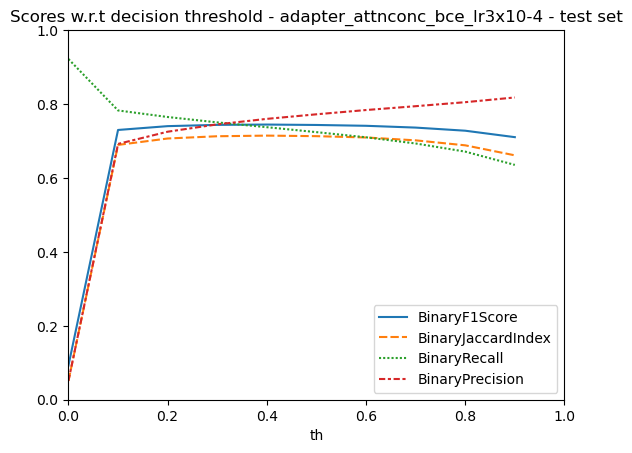

In [17]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores w.r.t decision threshold - lora_concat - test set')

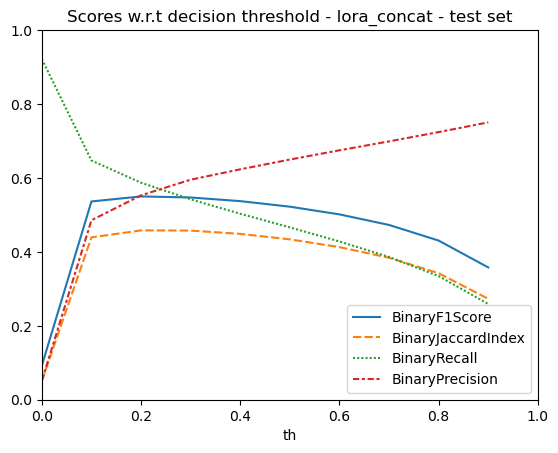

In [31]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [32]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.536455,0.439263,0.647242,0.485639
0.2,0.550009,0.458153,0.587128,0.552963
0.3,0.547200,0.457637,0.542211,0.595356
0.4,0.537310,0.448739,0.503135,0.623360
0.5,0.522283,0.433845,0.466304,0.649807
0.6,0.501471,0.412864,0.428111,0.674824
0.7,0.472861,0.384038,0.386238,0.698962
0.8,0.430607,0.342285,0.334479,0.724117


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_concat - test set')

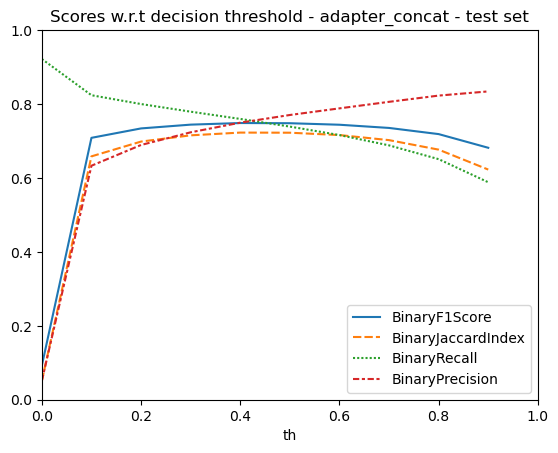

In [12]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [13]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.708568,0.658449,0.823860,0.633089
0.2,0.734045,0.698454,0.799966,0.689255
0.3,0.744273,0.715330,0.779357,0.723501
0.4,0.748629,0.722763,0.759728,0.749624
0.5,0.748098,0.722441,0.738983,0.770367
0.6,0.744012,0.716074,0.716072,0.788306
0.7,0.735345,0.702348,0.688180,0.805981
0.8,0.718673,0.676629,0.650869,0.822859


Text(0.5, 1.0, 'Scores w.r.t decision threshold - probing_concat_baseline - test set')

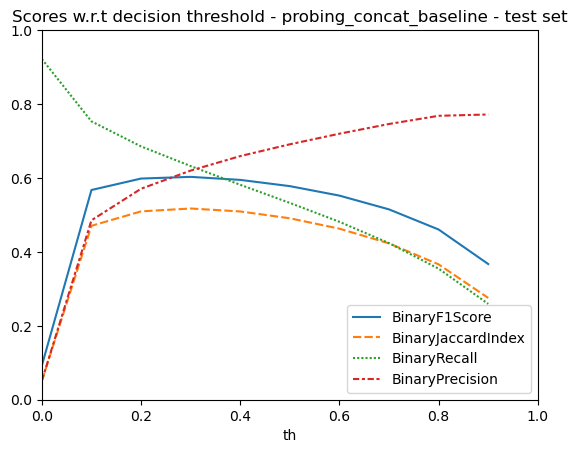

In [20]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores based decision threshold - probing_concat_baseline')

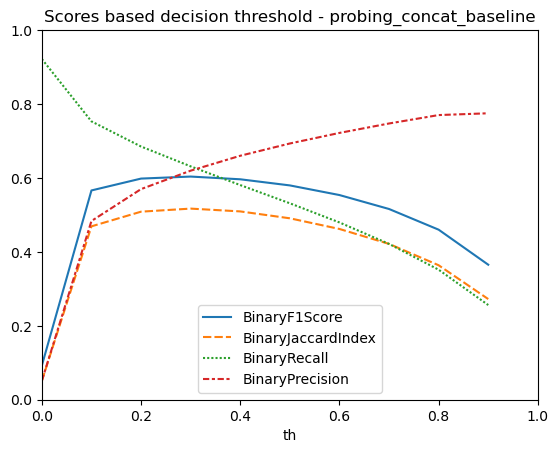

In [38]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [21]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.567399,0.470487,0.753143,0.485380
0.2,0.598393,0.509590,0.685396,0.570842
0.3,0.602961,0.517365,0.632196,0.619935
0.4,0.594774,0.509405,0.581527,0.659160
0.5,0.577878,0.490894,0.532516,0.691078
0.6,0.552220,0.462766,0.481348,0.719750
0.7,0.514960,0.422997,0.423583,0.746034
0.8,0.460479,0.366174,0.354578,0.768174


In [35]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.566229,0.469083,0.753108,0.483547
0.2,0.598322,0.508797,0.685064,0.569864
0.3,0.603792,0.517091,0.631404,0.619719
0.4,0.596410,0.509497,0.580730,0.660067
0.5,0.579846,0.490847,0.531492,0.693277
0.6,0.553774,0.461988,0.479626,0.721880
0.7,0.516029,0.421604,0.421558,0.747399
0.8,0.460049,0.363825,0.351758,0.770179


## Annexes

### Influence des values null : missing labels ?

In [46]:
df[(df.BinaryJaccardIndex > 0) & (~df.BinaryJaccardIndex.isna())].groupby("th")[metrics_col].mean()

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.100353,0.055260,1.000000,0.055260
0.1,0.624804,0.477171,0.831016,0.533569
0.2,0.665959,0.522070,0.762506,0.634284
0.3,0.677942,0.535234,0.708945,0.695825
0.4,0.675580,0.532041,0.657818,0.747687
0.5,0.662681,0.517143,0.607419,0.792317
0.6,0.632884,0.486738,0.548144,0.825006
0.7,0.595061,0.448192,0.486121,0.861865
0.8,0.535330,0.390285,0.409318,0.896209


+0.1 en enlevant les nan et 0 :o

<Axes: >

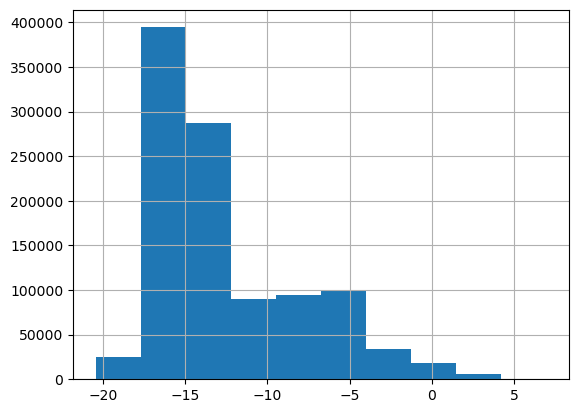

In [48]:
pd.Series(preds.flatten()).hist()

<Axes: >

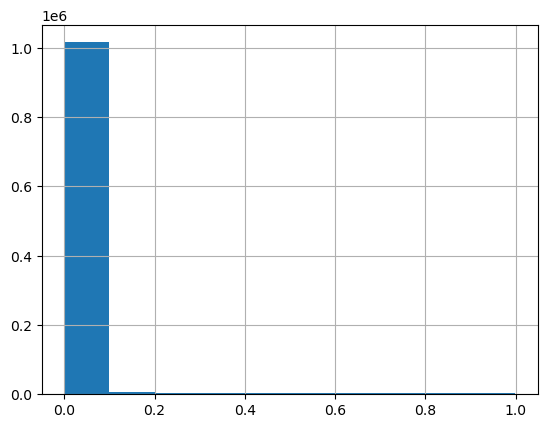

In [49]:
pd.Series(nn.Sigmoid()(preds.flatten())).hist()

<Axes: >

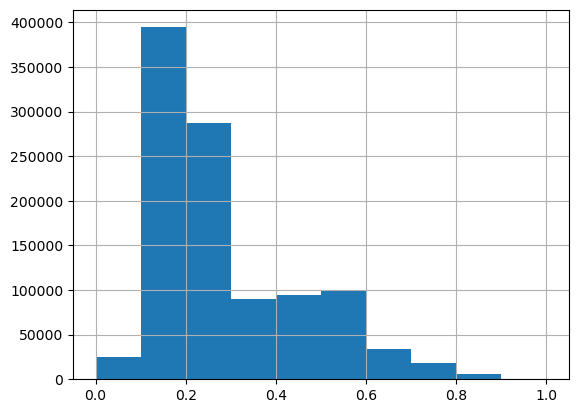

In [50]:
pd.Series(shift_range_values(preds.flatten())).hist()

In [ ]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)


In [26]:
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.zeros(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

## Annexe

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision, Recall, Precision

exp_name = "_adapter_concat"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False

report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)

labels_track = []
df_all_th = []
th_list = np.arange(0., 1, 0.1)
scores = dict(zip(th_list, [[] for _ in range(len(th_list))]))

cfg, data_module, module = load_exp(exp_name)
ds = get_ds(ds_type, data_module)
dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)

module = module.to(device)
sgmd = nn.Sigmoid()

@torch.no_grad()
def _step(module, batch, device):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label

def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)
    
# micro metrics compute metrics on global counts TP, FP, etc - need to keep track them
eval_engine_micro = {
    th: MetricCollection(
            Recall(threshold=th, average="micro", task="binary"),
            Precision(threshold=th, average="micro", task="binary")
    ).to(device) for th in th_list
}
for i, batch in enumerate(tqdm(dloader)):
    
    preds, label = _step(module, batch, device)

    if save_preds:
        fname = f"pred_{Path(batch['label_path'].stem)}.pt"
        folder = check_dir(report_dir, f"pred_{ds_type}")
        torch.save(preds, make_path(fname, folder))
    
    for th in th_list:
    #     metrics = [
    #         BinaryF1Score(threshold=th),
    #         BinaryJaccardIndex(threshold=th),
    #         # define_micro average
    #         BinaryRecall(threshold=th),
    #         BinaryPrecision(threshold=th),
    #     ]
    #     eval_engine = MetricCollection(metrics).to(device)
    #     scores[th].append(eval_engine(preds, label))
        eval_engine_micro[th].update(preds, label)

    labels_track.append(next(iter(batch["label_path"])))
    
scores_micro = {th: eval_engine_micro[th].compute() for th in th_list}
df_micro = pd.DataFrame(scores_micro).map(float).T
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)

# for th, res in scores.items():
#     df_score = pd.DataFrame(res).map(float)
#     df_score = df_score.assign(
#         label_path=labels_track,
#         th=th
#     )
#     df_all_th.append(df_score)
# df_all_th = pd.concat(df_all_th)
# df_all_th.to_csv(make_path(f"{exp_name}.csv", report_dir), index=True)
df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]
#adpater_concat_all_metrics = pd.concat([all_scores.loc["adapter_concat"], (df_micro.loc[th].round(3)*100)], axis=0)
df_all_th.to_csv(make_path(f"{exp_name}_scores_micro.csv", report_dir), index=True)